In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss, accuracy_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def read_atp_data(years):
    """
    Reads ATP matches data from CSV files for the specified years.

    Args:
        years (list or range): A list or range of years to read data for.

    Returns:
        pandas.DataFrame: A combined DataFrame containing all the data from the specified years.
    """
    data = []
    for year in years:
        # Check for Excel file with .xls extension
        xls_file_path = f"{year}.xls"
        if os.path.exists(xls_file_path):
            df = pd.read_excel(xls_file_path)
            data.append(df)
            continue

        # Check for Excel file with .xlsx extension
        xlsx_file_path = f"{year}.xlsx"
        if os.path.exists(xlsx_file_path):
            df = pd.read_excel(xlsx_file_path)
            data.append(df)
            continue

        # If the file is not found
        print(f"File not found: {xls_file_path}, or {xlsx_file_path}")

    if data:
        combined_data = pd.concat(data, ignore_index=True)
        return combined_data
    else:
        return None

In [2]:
def compute_point_difference(df):
    df.rename(columns={
        'Winner': 'winner_name',
        'Loser': 'loser_name',
        'WRank': 'winner_rank',
        'LRank': 'loser_rank',
        'WPts': 'winner_rank_points',
        'LPts': 'loser_rank_points',
        'Date': 'tourney_date'
    }, inplace=True)
    df["loser_rank"] = df["loser_rank"].fillna(100000)
    df["winner_rank"] = df["winner_rank"].fillna(100000)

    df["higher_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["winner_rank_points"], df["loser_rank_points"])
    df["lower_rank_points"] = np.where(df["winner_rank"] < df["loser_rank"], df["loser_rank_points"], df["winner_rank_points"])
    
    df["point_difference"] = df["higher_rank_points"] - df["lower_rank_points"]
    df["higher_rank_won"] = df["winner_rank"] < df["loser_rank"]
    df.dropna(inplace=True, subset=["point_difference"])
    df = df[~df['Comment'].isin(['Retired', 'Walkover'])]
    return df

In [3]:
def accuracy(pred, actual):
    return np.mean(pred == actual)

def calibration(prob, actual):
    return np.mean(prob) / np.mean(actual)

def log_loss(prob, actual):
    return -np.mean(actual * np.log(prob) + (1 - actual) * np.log(1 - prob))

def validation_stats_calculate(df):
    acc = accuracy(df["pred"], df["actual"])
    calib = calibration(df["prob"], df["actual"])
    ll = log_loss(df["prob"], df["actual"])
    return {"accuracy": acc, "calibration": calib, "log_loss": ll}

def validation_stats(df, model_name=None):
    stats = validation_stats_calculate(df)
    print(f"{model_name}")
    print(f" - Accuracy: {stats['accuracy']:.4f}")
    print(f" - Calibration: {stats['calibration']:.4f}")
    print(f" - Log Loss: {stats['log_loss']:.4f}")
    print("--------------------------------------")
    return stats

def make_predictions(df):
    df["pred"] = df["prob"] > 0.5
    return df

In [4]:
def get_elo_prob(elo1, elo2):
    return 1 / (1 + 10 ** ((elo2 - elo1) / 400))

In [5]:
def update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches):
    prob = get_elo_prob(winner_elo, loser_elo)
    k_winner = k_func(winner_matches)
    k_loser = k_func(loser_matches)
    winner_elo += k_winner * (1 - prob)
    loser_elo += k_loser * (0 - (1 - prob))
    return winner_elo, loser_elo

In [6]:
def implement_elo(df, k_func):
    elo_ratings = {}
    matches_played = {}
    df_elo = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches)

        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo
        matches_played[winner] = winner_matches + 1
        matches_played[loser] = loser_matches + 1

        df_elo.at[index, "elo_prob"] = get_elo_prob(winner_new_elo, loser_new_elo)
        df_elo.at[index, "winner_elo_before_game"] = winner_elo
        df_elo.at[index, "loser_elo_before_game"] = loser_elo

    return df_elo, elo_ratings

In [7]:
def get_bcm_probabilities(df):
    def implied_prob(row, bookie):
        alpha_w = row[f"{bookie}W"]
        beta_l = row[f"{bookie}L"]
        return beta_l / (alpha_w + beta_l)
    
    bookmakers = ["B365", "PS"]
    implied_probs_winner = []
    implied_probs_loser = []
    
    for _, row in df.iterrows():
        probs_winner = [implied_prob(row, bookie) for bookie in bookmakers]
        probs_loser = [1 - prob for prob in probs_winner]
        implied_probs_winner.append(probs_winner)
        implied_probs_loser.append(probs_loser)
    
    df["implied_prob_winner"] = np.mean(implied_probs_winner, axis=1)
    df["implied_prob_loser"] = np.mean(implied_probs_loser, axis=1)

    df["implied_prob_winner_norm"] = df["implied_prob_winner"] / (df["implied_prob_winner"] + df["implied_prob_loser"])
    df["implied_prob_loser_norm"] = df["implied_prob_loser"] / (df["implied_prob_winner"] + df["implied_prob_loser"])

    df["bcm_prob"] = df["implied_prob_winner_norm"]
    return df

In [8]:
def execute_elo_model(df_train, df_test, k_func, model_name):
    df_elo_train, elo_ratings = implement_elo(df_train, k_func)
    prob_higher_rank = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i
        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_elo, loser_new_elo = update_elo(winner_elo, loser_elo, k_func, winner_matches, loser_matches)
        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo

    df_elo_test = df_test.copy()
    df_elo_test["prob"] = prob_higher_rank
    df_elo_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_elo_test = make_predictions(df_elo_test)
    stats = validation_stats(df_elo_test, model_name=model_name)

    return stats

In [9]:
years = range(2013, 2023)  # range of years from 2013 to 2023
df = read_atp_data(years)
df = compute_point_difference(df)
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format='%Y%m%d')
df_train = df[df["tourney_date"].dt.year < 2022].copy().reset_index(drop=True)
df_test = df[df["tourney_date"].dt.year == 2022].copy().reset_index(drop=True)

/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/oanh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
# Naive Model
naive_prob = df_train["higher_rank_won"].mean()
naive_prob_arr = np.repeat(naive_prob, df_test.shape[0])
df_naive = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": naive_prob_arr})
df_naive = make_predictions(df_naive)
validation_stats(df_naive, model_name="Naive Model")

# Logistic Regression Model
X_train = df_train[["point_difference"]]
y_train = df_train["higher_rank_won"]

logistic_model = LogisticRegression(fit_intercept=False)
logistic_model.fit(X_train, y_train)

logistic_prob_arr = logistic_model.predict_proba(df_test[["point_difference"]])[:, 1]
df_logistic = pd.DataFrame({"actual": df_test["higher_rank_won"], "prob": logistic_prob_arr})
df_logistic = make_predictions(df_logistic)
validation_stats(df_logistic, model_name="Logistic Regression")

Naive Model
 - Accuracy: 0.6428
 - Calibration: 1.0172
 - Log Loss: 0.6520
--------------------------------------
Logistic Regression
 - Accuracy: 0.6428
 - Calibration: 0.9533
 - Log Loss: 0.6401
--------------------------------------


{'accuracy': 0.6428290766208251,
 'calibration': 0.9532971043486245,
 'log_loss': 0.6400686572940905}

In [ ]:
# Implement BCM model on test data
df_test = get_bcm_probabilities(df_test)

df_bcm = df_test.copy()
df_bcm.rename(columns={"higher_rank_won": "actual"}, inplace=True)
df_bcm["prob"] = df_bcm["bcm_prob"]
df_bcm = make_predictions(df_bcm)
validation_stats(df_bcm, model_name="Bookmakers Consensus Model (BCM)")

In [11]:
def k_fixed(matches_played, k=32):
    return k
def k_538(matches_played, delta=100, nu=5, sigma=0.1):
    return delta / (matches_played + nu) ** sigma
# Elo Model with fixed K-factor
execute_elo_model(df_train, df_test, k_fixed, "ELO Model (K-factor)")
# Elo Model with k_538
execute_elo_model(df_train, df_test, k_538, "ELO Model (k_538)")

ELO Model (K-factor)
 - Accuracy: 0.6472
 - Calibration: 0.9953
 - Log Loss: 0.6165
--------------------------------------
ELO Model (k_538)
 - Accuracy: 0.6479
 - Calibration: 1.0243
 - Log Loss: 0.6267
--------------------------------------


{'accuracy': 0.6479371316306484,
 'calibration': 1.024320144669537,
 'log_loss': 0.6266581203826803}

## Elo Model (k-factor and k_538) hyperparameter optimising

In [21]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

In [14]:
space = [Real(1, 50, name='k')]

@use_named_args(space)
def objective(k):
    def k_func(matches_played, k=k):
        return k

    # Execute Elo model with current hyperparameters
    stats = execute_elo_model(df_train, df_test, k_func, model_name=f"ELO Model (K-factor) (k={k:.2f})")

    # Minimize the negative accuracy (maximize accuracy)
    return -stats['accuracy']

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_k = res_gp.x[0]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: k={best_k:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

ELO Model (k=30.05)
 - Accuracy: 0.6483
 - Calibration: 0.9924
 - Log Loss: 0.6162
--------------------------------------
ELO Model (k=42.37)
 - Accuracy: 0.6495
 - Calibration: 1.0066
 - Log Loss: 0.6194
--------------------------------------
ELO Model (k=43.04)
 - Accuracy: 0.6499
 - Calibration: 1.0072
 - Log Loss: 0.6196
--------------------------------------
ELO Model (k=42.52)
 - Accuracy: 0.6495
 - Calibration: 1.0067
 - Log Loss: 0.6194
--------------------------------------
ELO Model (k=31.55)
 - Accuracy: 0.6472
 - Calibration: 0.9947
 - Log Loss: 0.6164
--------------------------------------
ELO Model (k=19.83)
 - Accuracy: 0.6456
 - Calibration: 0.9705
 - Log Loss: 0.6164
--------------------------------------
ELO Model (k=15.58)
 - Accuracy: 0.6420
 - Calibration: 0.9557
 - Log Loss: 0.6183
--------------------------------------
ELO Model (k=3.78)
 - Accuracy: 0.6263
 - Calibration: 0.8618
 - Log Loss: 0.6444
--------------------------------------
ELO Model (k=14.36)
 - Ac

In [17]:
# Define the search space for hyperparameters
space = [Real(1, 50, name='k')]

@use_named_args(space)
def objective(k):
    def k_func(matches_played, k=k):
        return k

    # Execute Elo model with current hyperparameters
    stats = execute_elo_model(df_train, df_test, k_func, model_name=f"ELO Model (K-factor) (k={k:.2f})")

    # Minimize the negative log loss (maximize log loss)
    return stats['log_loss']

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_k = res_gp.x[0]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: k={best_k:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

ELO Model (k=30.05)
 - Accuracy: 0.6483
 - Calibration: 0.9924
 - Log Loss: 0.6162
--------------------------------------
ELO Model (k=42.37)
 - Accuracy: 0.6495
 - Calibration: 1.0066
 - Log Loss: 0.6194
--------------------------------------
ELO Model (k=43.04)
 - Accuracy: 0.6499
 - Calibration: 1.0072
 - Log Loss: 0.6196
--------------------------------------
ELO Model (k=42.52)
 - Accuracy: 0.6495
 - Calibration: 1.0067
 - Log Loss: 0.6194
--------------------------------------
ELO Model (k=31.55)
 - Accuracy: 0.6472
 - Calibration: 0.9947
 - Log Loss: 0.6164
--------------------------------------
ELO Model (k=19.83)
 - Accuracy: 0.6456
 - Calibration: 0.9705
 - Log Loss: 0.6164
--------------------------------------
ELO Model (k=15.58)
 - Accuracy: 0.6420
 - Calibration: 0.9557
 - Log Loss: 0.6183
--------------------------------------
ELO Model (k=3.78)
 - Accuracy: 0.6263
 - Calibration: 0.8618
 - Log Loss: 0.6444
--------------------------------------
ELO Model (k=14.36)
 - Ac

In [18]:
# Define the search space for hyperparameters
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538(matches_played, delta=delta, nu=nu, sigma=sigma):
        return delta / (matches_played + nu) ** sigma

    stats = execute_elo_model(df_train, df_test, k_538, model_name=f"ELO Model (k_538) (delta={delta:.2f}, nu={nu:.2f}, sigma={sigma:.2f})")
    return -stats['accuracy']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_delta = res_gp.x[0]
best_nu = res_gp.x[1]
best_sigma = res_gp.x[2]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: delta={best_delta:.2f}, nu={best_nu:.2f}, sigma={best_sigma:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

ELO Model (k_538) (delta=337.00, nu=43.00, sigma=0.87)
 - Accuracy: 0.6169
 - Calibration: 0.8596
 - Log Loss: 0.6473
--------------------------------------
ELO Model (k_538) (delta=439.00, nu=33.00, sigma=0.45)
 - Accuracy: 0.6475
 - Calibration: 1.0228
 - Log Loss: 0.6283
--------------------------------------
ELO Model (k_538) (delta=219.00, nu=8.00, sigma=0.35)
 - Accuracy: 0.6472
 - Calibration: 1.0187
 - Log Loss: 0.6261
--------------------------------------
ELO Model (k_538) (delta=291.00, nu=42.00, sigma=0.53)
 - Accuracy: 0.6346
 - Calibration: 0.9721
 - Log Loss: 0.6241
--------------------------------------
ELO Model (k_538) (delta=257.00, nu=43.00, sigma=0.40)
 - Accuracy: 0.6428
 - Calibration: 1.0032
 - Log Loss: 0.6225
--------------------------------------
ELO Model (k_538) (delta=359.00, nu=22.00, sigma=0.96)
 - Accuracy: 0.6149
 - Calibration: 0.8493
 - Log Loss: 0.6522
--------------------------------------
ELO Model (k_538) (delta=156.00, nu=44.00, sigma=0.53)
 - A

In [19]:
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538(matches_played, delta=delta, nu=nu, sigma=sigma):
        return delta / (matches_played + nu) ** sigma

    stats = execute_elo_model(df_train, df_test, k_538, model_name=f"ELO Model (k_538) (delta={delta:.2f}, nu={nu:.2f}, sigma={sigma:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_delta = res_gp.x[0]
best_nu = res_gp.x[1]
best_sigma = res_gp.x[2]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: delta={best_delta:.2f}, nu={best_nu:.2f}, sigma={best_sigma:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

ELO Model (k_538) (delta=337.00, nu=43.00, sigma=0.87)
 - Accuracy: 0.6169
 - Calibration: 0.8596
 - Log Loss: 0.6473
--------------------------------------
ELO Model (k_538) (delta=439.00, nu=33.00, sigma=0.45)
 - Accuracy: 0.6475
 - Calibration: 1.0228
 - Log Loss: 0.6283
--------------------------------------
ELO Model (k_538) (delta=219.00, nu=8.00, sigma=0.35)
 - Accuracy: 0.6472
 - Calibration: 1.0187
 - Log Loss: 0.6261
--------------------------------------
ELO Model (k_538) (delta=291.00, nu=42.00, sigma=0.53)
 - Accuracy: 0.6346
 - Calibration: 0.9721
 - Log Loss: 0.6241
--------------------------------------
ELO Model (k_538) (delta=257.00, nu=43.00, sigma=0.40)
 - Accuracy: 0.6428
 - Calibration: 1.0032
 - Log Loss: 0.6225
--------------------------------------
ELO Model (k_538) (delta=359.00, nu=22.00, sigma=0.96)
 - Accuracy: 0.6149
 - Calibration: 0.8493
 - Log Loss: 0.6522
--------------------------------------
ELO Model (k_538) (delta=156.00, nu=44.00, sigma=0.53)
 - A

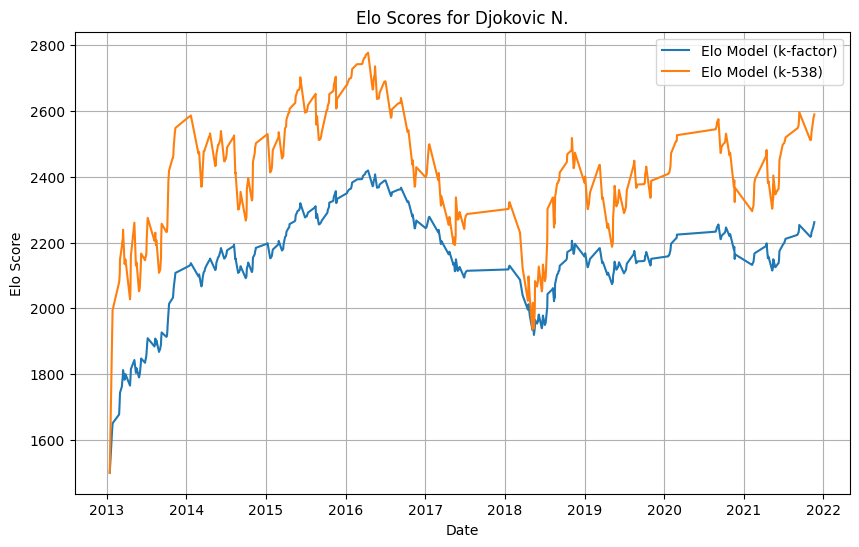

In [89]:
def get_individual_data(df, player_name, rating_column):
    player_mask = (df["winner_name"] == player_name) | (df["loser_name"] == player_name)
    df_player = df[player_mask].copy()
    player_won = df_player["winner_name"] == player_name

    df_player[rating_column + "_before_game"] = np.where(player_won, df_player["winner_" + rating_column + "_before_game"], df_player["loser_" + rating_column + "_before_game"])
    df_player = df_player.sort_values("tourney_date")
    return df_player

def plot_ratings(player_name, df_players, labels, rating_column):
    plt.figure(figsize=(10, 6))
    for df_player, label in zip(df_players, labels):
        plt.plot(df_player["tourney_date"], df_player["winner_" + rating_column + "_before_game"], label=label)
    plt.title(f"{rating_column.capitalize()} Scores for {player_name}")
    plt.xlabel("Date")
    plt.ylabel(f"{rating_column.capitalize()} Score")
    plt.legend()
    plt.grid(True)
    plt.show()

player_name = "Djokovic N."

df_elo_train_fixed, _ = implement_elo(df_train, lambda matches_played: k_fixed(matches_played, k=48.17))
df_elo_train_538, _ = implement_elo(df_train, lambda matches_played: k_538(matches_played, delta=196.00, nu=7.00, sigma=0.10))

df_player_k_factor = get_individual_data(df_elo_train_fixed, player_name, "elo")
df_player_538 = get_individual_data(df_elo_train_538, player_name, "elo")

df_players = [df_player_k_factor, df_player_538]
labels = ["Elo Model (k-factor)", "Elo Model (k-538)"]
plot_ratings(player_name, df_players, labels, "elo")

## Margin of Victory

In [22]:
def update_elo_with_margin(winner_elo, loser_elo, k_func, winner_matches, loser_matches, margin):
    prob = get_elo_prob(winner_elo, loser_elo)
    k_winner = k_func(winner_matches, margin)
    k_loser = k_func(loser_matches, margin)
    winner_elo += k_winner * (1 - prob)
    loser_elo += k_loser * (0 - (1 - prob))
    return winner_elo, loser_elo

def implement_elo_with_margin(df, k_func):
    elo_ratings = {}
    matches_played = {}
    df_elo = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        margin_of_victory = row["Wsets"] - row["Lsets"]

        winner_elo = elo_ratings.get(winner, 1500)
        loser_elo = elo_ratings.get(loser, 1500)
        winner_matches = matches_played.get(winner, 0)
        loser_matches = matches_played.get(loser, 0)

        winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_func, winner_matches, loser_matches, margin)

        elo_ratings[winner] = winner_new_elo
        elo_ratings[loser] = loser_new_elo
        matches_played[winner] = winner_matches + 1
        matches_played[loser] = loser_matches + 1

        df_elo.at[index, "elo_prob"] = get_elo_prob(winner_new_elo, loser_new_elo)
        df_elo.at[index, "winner_elo_before_game"] = winner_elo
        df_elo.at[index, "loser_elo_before_game"] = loser_elo

    return df_elo, elo_ratings

def execute_elo_with_margin(df_train, df_test, k_margin_func, model_name):
    df_elo_train_margin, elo_ratings_margin = implement_elo_with_margin(df_train, k_margin_func)
    prob_higher_rank_margin = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        margin_of_victory = row["Wsets"] - row["Lsets"]

        winner_elo = elo_ratings_margin.get(winner, 1500)
        loser_elo = elo_ratings_margin.get(loser, 1500)
        winner_matches = df_train[df_train["winner_name"] == winner].shape[0] + i
        loser_matches = df_train[df_train["loser_name"] == loser].shape[0] + i

        prob = get_elo_prob(winner_elo, loser_elo)
        prob_higher_rank_margin.append(prob if row["higher_rank_won"] else 1 - prob)

        winner_new_elo, loser_new_elo = update_elo_with_margin(winner_elo, loser_elo, k_margin_func, winner_matches, loser_matches, margin)
        elo_ratings_margin[winner] = winner_new_elo
        elo_ratings_margin[loser] = loser_new_elo

    df_margin_test = df_test.copy()
    df_margin_test["prob"] = prob_higher_rank_margin
    df_margin_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_margin_test = make_predictions(df_margin_test)
    stats = validation_stats(df_margin_test, model_name=model_name)
    
    return stats

In [23]:
def k_margin_func(matches_played, margin, k=32, margin_factor=17):
    return k + margin_factor * margin

def k_538_with_margin(matches_played, margin, delta=100, nu=5, sigma=0.1):
    return (delta * margin) / (matches_played + nu) ** sigma

execute_elo_with_margin(df_train, df_test, k_margin_func, "ELO Model (k-factor with margin)")
execute_elo_with_margin(df_train, df_test, k_538_with_margin, "ELO Model (k_538 with margin)")

ELO Model (k-factor with margin)
 - Accuracy: 0.6487
 - Calibration: 1.0265
 - Log Loss: 0.6274
--------------------------------------
ELO Model (k_538 with margin)
 - Accuracy: 0.6499
 - Calibration: 1.0527
 - Log Loss: 0.6561
--------------------------------------


{'accuracy': 0.649901768172888,
 'calibration': 1.0527401749534975,
 'log_loss': 0.6560747833356303}

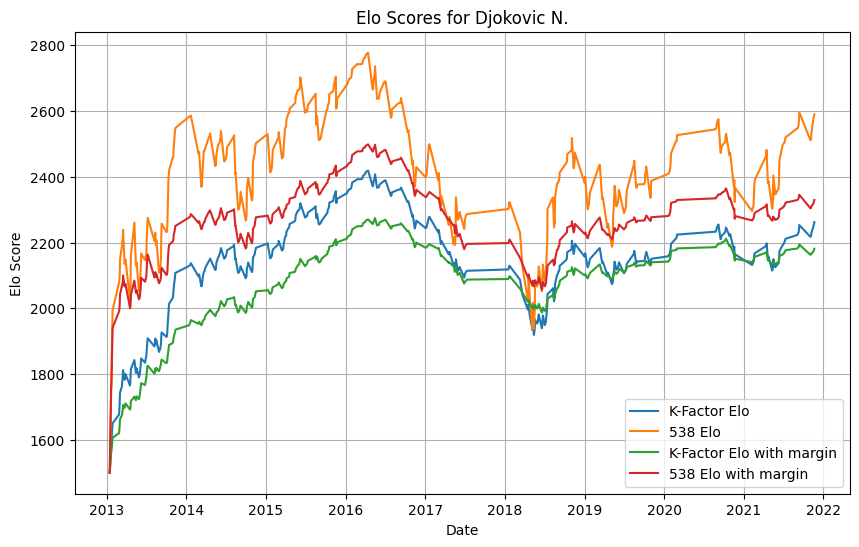

In [80]:
df_elo_train_fixed_with_margin, _ = implement_elo_with_margin(df_train, lambda matches_played, margin: k_margin_func(matches_played, margin, k=1.00, margin_factor=13.38))
df_elo_train_538_with_margin, _ = implement_elo_with_margin(df_train, lambda matches_played, margin: k_538_with_margin(matches_played, margin, delta=100.00, nu=5.00, sigma=0.27))

df_player_k_factor_with_margin = get_individual_data(df_elo_train_fixed_with_margin, player_name, "elo")
df_player_538_with_margin = get_individual_data(df_elo_train_538_with_margin, player_name, "elo")

df_players = [df_player_k_factor, df_player_538, df_player_k_factor_with_margin, df_player_538_with_margin]
labels = ["K-Factor Elo", "538 Elo", "K-Factor Elo with margin", "538 Elo with margin"]
plot_ratings(player_name, df_players, labels, "elo")

In [26]:
space  = [
    Real(1, 50, name='k'),
    Real(5, 50, name='margin_factor')
]

@use_named_args(space)
def objective(k, margin_factor):
    def k_margin_func(matches_played, margin, k=k, margin_factor=margin_factor):
        return k + margin_factor * margin

    # Execute Elo model with current hyperparameters
    stats = execute_elo_with_margin(df_train, df_test, k_margin_func, model_name=f"ELO Model (k-factor with margin) (k={k:.2f}, margin_factor={margin_factor:.2f})")

    # Minimize the negative accuracy (maximize accuracy)
    return -stats['accuracy']

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_k = res_gp.x[0]
best_margin_factor = res_gp.x[1]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: k={best_k:.2f}, margin_factor={best_margin_factor:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

ELO Model (k-factor with margin) (k=30.05, margin_factor=42.99)
 - Accuracy: 0.6460
 - Calibration: 1.0387
 - Log Loss: 0.6549
--------------------------------------
ELO Model (k-factor with margin) (k=43.04, margin_factor=43.13)
 - Accuracy: 0.6452
 - Calibration: 1.0384
 - Log Loss: 0.6635
--------------------------------------
ELO Model (k-factor with margin) (k=31.55, margin_factor=22.30)
 - Accuracy: 0.6464
 - Calibration: 1.0306
 - Log Loss: 0.6322
--------------------------------------
ELO Model (k-factor with margin) (k=15.58, margin_factor=7.55)
 - Accuracy: 0.6483
 - Calibration: 0.9984
 - Log Loss: 0.6156
--------------------------------------
ELO Model (k-factor with margin) (k=14.36, margin_factor=26.49)
 - Accuracy: 0.6511
 - Calibration: 1.0309
 - Log Loss: 0.6282
--------------------------------------
ELO Model (k-factor with margin) (k=40.80, margin_factor=26.60)
 - Accuracy: 0.6475
 - Calibration: 1.0338
 - Log Loss: 0.6418
--------------------------------------
ELO M

In [28]:
space  = [
    Real(1, 50, name='k'),
    Real(5, 50, name='margin_factor')
]

@use_named_args(space)
def objective(k, margin_factor):
    def k_margin_func(matches_played, margin, k=k, margin_factor=margin_factor):
        return k + margin_factor * margin

    # Execute Elo model with current hyperparameters
    stats = execute_elo_with_margin(df_train, df_test, k_margin_func, model_name=f"ELO Model (k-factor with margin) (k={k:.2f}, margin_factor={margin_factor:.2f})")

    # Minimize the negative accuracy (maximize accuracy)
    return stats['log_loss']

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_k = res_gp.x[0]
best_margin_factor = res_gp.x[1]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: k={best_k:.2f}, margin_factor={best_margin_factor:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

ELO Model (k-factor with margin) (k=30.05, margin_factor=42.99)
 - Accuracy: 0.6460
 - Calibration: 1.0387
 - Log Loss: 0.6549
--------------------------------------
ELO Model (k-factor with margin) (k=43.04, margin_factor=43.13)
 - Accuracy: 0.6452
 - Calibration: 1.0384
 - Log Loss: 0.6635
--------------------------------------
ELO Model (k-factor with margin) (k=31.55, margin_factor=22.30)
 - Accuracy: 0.6464
 - Calibration: 1.0306
 - Log Loss: 0.6322
--------------------------------------
ELO Model (k-factor with margin) (k=15.58, margin_factor=7.55)
 - Accuracy: 0.6483
 - Calibration: 0.9984
 - Log Loss: 0.6156
--------------------------------------
ELO Model (k-factor with margin) (k=14.36, margin_factor=26.49)
 - Accuracy: 0.6511
 - Calibration: 1.0309
 - Log Loss: 0.6282
--------------------------------------
ELO Model (k-factor with margin) (k=40.80, margin_factor=26.60)
 - Accuracy: 0.6475
 - Calibration: 1.0338
 - Log Loss: 0.6418
--------------------------------------
ELO M

In [29]:
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538_with_margin(matches_played, margin, delta=delta, nu=nu, sigma=sigma):
        return (delta * margin) / (matches_played + nu) ** sigma
    
    stats = execute_elo_with_margin(df_train, df_test, k_538_with_margin, model_name=f"ELO Model (k_538 with margin) (delta={delta:.2f}, nu={nu:.2f}, sigma={sigma:.2f})")
    return -stats['accuracy']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_delta = res_gp.x[0]
best_nu = res_gp.x[1]
best_sigma = res_gp.x[2]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: delta={best_delta:.2f}, nu={best_nu:.2f}, sigma={best_sigma:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

ELO Model (k_538 with margin) (delta=337.00, nu=43.00, sigma=0.87)
 - Accuracy: 0.6251
 - Calibration: 0.9068
 - Log Loss: 0.6375
--------------------------------------
ELO Model (k_538 with margin) (delta=439.00, nu=33.00, sigma=0.45)
 - Accuracy: 0.6503
 - Calibration: 1.0622
 - Log Loss: 0.6457
--------------------------------------
ELO Model (k_538 with margin) (delta=219.00, nu=8.00, sigma=0.35)
 - Accuracy: 0.6519
 - Calibration: 1.0590
 - Log Loss: 0.6418
--------------------------------------
ELO Model (k_538 with margin) (delta=291.00, nu=42.00, sigma=0.53)
 - Accuracy: 0.6491
 - Calibration: 1.0232
 - Log Loss: 0.6292
--------------------------------------
ELO Model (k_538 with margin) (delta=257.00, nu=43.00, sigma=0.40)
 - Accuracy: 0.6542
 - Calibration: 1.0468
 - Log Loss: 0.6325
--------------------------------------
ELO Model (k_538 with margin) (delta=359.00, nu=22.00, sigma=0.96)
 - Accuracy: 0.6216
 - Calibration: 0.8932
 - Log Loss: 0.6432
--------------------------

In [30]:
space  = [
    Integer(100, 500, name='delta'),
    Integer(5, 50, name='nu'),
    Real(0.1, 1.0, name='sigma')
]

@use_named_args(space)
def objective(delta, nu, sigma):
    def k_538_with_margin(matches_played, margin, delta=delta, nu=nu, sigma=sigma):
        return (delta * margin) / (matches_played + nu) ** sigma
    
    stats = execute_elo_with_margin(df_train, df_test, k_538_with_margin, model_name=f"ELO Model (k_538 with margin) (delta={delta:.2f}, nu={nu:.2f}, sigma={sigma:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_delta = res_gp.x[0]
best_nu = res_gp.x[1]
best_sigma = res_gp.x[2]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: delta={best_delta:.2f}, nu={best_nu:.2f}, sigma={best_sigma:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

ELO Model (k_538 with margin) (delta=337.00, nu=43.00, sigma=0.87)
 - Accuracy: 0.6251
 - Calibration: 0.9068
 - Log Loss: 0.6375
--------------------------------------
ELO Model (k_538 with margin) (delta=439.00, nu=33.00, sigma=0.45)
 - Accuracy: 0.6503
 - Calibration: 1.0622
 - Log Loss: 0.6457
--------------------------------------
ELO Model (k_538 with margin) (delta=219.00, nu=8.00, sigma=0.35)
 - Accuracy: 0.6519
 - Calibration: 1.0590
 - Log Loss: 0.6418
--------------------------------------
ELO Model (k_538 with margin) (delta=291.00, nu=42.00, sigma=0.53)
 - Accuracy: 0.6491
 - Calibration: 1.0232
 - Log Loss: 0.6292
--------------------------------------
ELO Model (k_538 with margin) (delta=257.00, nu=43.00, sigma=0.40)
 - Accuracy: 0.6542
 - Calibration: 1.0468
 - Log Loss: 0.6325
--------------------------------------
ELO Model (k_538 with margin) (delta=359.00, nu=22.00, sigma=0.96)
 - Accuracy: 0.6216
 - Calibration: 0.8932
 - Log Loss: 0.6432
--------------------------

## Glicko Model 

In [35]:
def glicko_rating_update(r, RD, r_opponent, RD_opponent, outcome, c, t):
    q = np.log(10) / 400
    g = 1 / np.sqrt(1 + 3 * q**2 * RD_opponent**2 / np.pi**2)
    E = 1 / (1 + 10 ** (g * (r - r_opponent) / -400))
    
    d2_inv = q**2 * g**2 * E * (1 - E)
    d2 = 1 / d2_inv
    
    RD_prime = np.sqrt(1 / (1 / RD**2 + 1 / d2))
    r_prime = r + q / (1 / RD**2 + 1 / d2) * g * (outcome - E)
    
    RD_new = np.sqrt(RD_prime**2 + c**2 * t)
    return r_prime, min(RD_new, 350)

def implement_glicko(df, c, t):
    ratings = {}
    rating_deviations = {}
    df_glicko = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        
        winner_rating = ratings.get(winner, 1500)
        loser_rating = ratings.get(loser, 1500)
        winner_RD = rating_deviations.get(winner, 350)
        loser_RD = rating_deviations.get(loser, 350)
        
        winner_new_rating, winner_new_RD = glicko_rating_update(winner_rating, winner_RD, loser_rating, loser_RD, 1, c, t)
        loser_new_rating, loser_new_RD = glicko_rating_update(loser_rating, loser_RD, winner_rating, winner_RD, 0, c, t)
        
        ratings[winner] = winner_new_rating
        rating_deviations[winner] = winner_new_RD
        ratings[loser] = loser_new_rating
        rating_deviations[loser] = loser_new_RD

        prob = 1 / (1 + 10 ** ((loser_new_rating - winner_new_rating) / 400))
        df_glicko.at[index, "glicko_prob"] = prob
        df_glicko.at[index, "winner_glicko_before_game"] = winner_rating
        df_glicko.at[index, "loser_glicko_before_game"] = loser_rating

    return df_glicko, ratings, rating_deviations

def execute_glicko(df_train, df_test, c, t, model_name):
    df_glicko_train, glicko_ratings, glicko_rds = implement_glicko(df_train, c, t)
    prob_higher_rank_glicko = []
    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = glicko_ratings.get(winner, 1500)
        loser_rating = glicko_ratings.get(loser, 1500)
        winner_RD = glicko_rds.get(winner, 350)
        loser_RD = glicko_rds.get(loser, 350)

        prob = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
        prob_higher_rank_glicko.append(prob if row["higher_rank_won"] else 1 - prob)

        winner_new_rating, winner_new_RD = glicko_rating_update(winner_rating, winner_RD, loser_rating, loser_RD, 1, c, t)
        loser_new_rating, loser_new_RD = glicko_rating_update(loser_rating, loser_RD, winner_rating, winner_RD, 0, c, t)

        glicko_ratings[winner] = winner_new_rating
        glicko_rds[winner] = winner_new_RD
        glicko_ratings[loser] = loser_new_rating
        glicko_rds[loser] = loser_new_RD

    df_glicko_test = df_test.copy()
    df_glicko_test["prob"] = prob_higher_rank_glicko
    df_glicko_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_glicko_test = make_predictions(df_glicko_test)
    stats = validation_stats(df_glicko_test, model_name=model_name)

    return stats

In [36]:
execute_glicko(df_train, df_test, 34.6, 1, "Glicko Model")

Glicko Model
 - Accuracy: 0.6483
 - Calibration: 1.0279
 - Log Loss: 0.6430
--------------------------------------


{'accuracy': 0.6483300589390962,
 'calibration': 1.0279355710571205,
 'log_loss': 0.643042634102862}

In [37]:
space = [
    Real(10, 50, name='c')
]

@use_named_args(space)
def objective(c):
    stats = execute_glicko(df_train, df_test, c, t=1, model_name=f"Glicko Model (c={c:.2f})")
    return -stats['accuracy']
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_c = res_gp.x[0]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: c={best_c:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

Glicko Model (c=33.71)
 - Accuracy: 0.6495
 - Calibration: 1.0275
 - Log Loss: 0.6419
--------------------------------------
Glicko Model (c=43.77)
 - Accuracy: 0.6448
 - Calibration: 1.0312
 - Log Loss: 0.6560
--------------------------------------
Glicko Model (c=44.32)
 - Accuracy: 0.6456
 - Calibration: 1.0313
 - Log Loss: 0.6568
--------------------------------------
Glicko Model (c=43.89)
 - Accuracy: 0.6448
 - Calibration: 1.0312
 - Log Loss: 0.6561
--------------------------------------
Glicko Model (c=34.94)
 - Accuracy: 0.6483
 - Calibration: 1.0281
 - Log Loss: 0.6435
--------------------------------------
Glicko Model (c=25.38)
 - Accuracy: 0.6546
 - Calibration: 1.0218
 - Log Loss: 0.6320
--------------------------------------
Glicko Model (c=21.90)
 - Accuracy: 0.6542
 - Calibration: 1.0181
 - Log Loss: 0.6285
--------------------------------------
Glicko Model (c=12.27)
 - Accuracy: 0.6487
 - Calibration: 0.9999
 - Log Loss: 0.6219
--------------------------------------


In [38]:
space = [
    Real(10, 50, name='c')
]

@use_named_args(space)
def objective(c):
    stats = execute_glicko(df_train, df_test, c, t=1, model_name=f"Glicko Model (c={c:.2f})")
    return stats['log_loss']
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_c = res_gp.x[0]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: c={best_c:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

Glicko Model (c=33.71)
 - Accuracy: 0.6495
 - Calibration: 1.0275
 - Log Loss: 0.6419
--------------------------------------
Glicko Model (c=43.77)
 - Accuracy: 0.6448
 - Calibration: 1.0312
 - Log Loss: 0.6560
--------------------------------------
Glicko Model (c=44.32)
 - Accuracy: 0.6456
 - Calibration: 1.0313
 - Log Loss: 0.6568
--------------------------------------
Glicko Model (c=43.89)
 - Accuracy: 0.6448
 - Calibration: 1.0312
 - Log Loss: 0.6561
--------------------------------------
Glicko Model (c=34.94)
 - Accuracy: 0.6483
 - Calibration: 1.0281
 - Log Loss: 0.6435
--------------------------------------
Glicko Model (c=25.38)
 - Accuracy: 0.6546
 - Calibration: 1.0218
 - Log Loss: 0.6320
--------------------------------------
Glicko Model (c=21.90)
 - Accuracy: 0.6542
 - Calibration: 1.0181
 - Log Loss: 0.6285
--------------------------------------
Glicko Model (c=12.27)
 - Accuracy: 0.6487
 - Calibration: 0.9999
 - Log Loss: 0.6219
--------------------------------------


In [44]:
from scipy.optimize import root_scalar
from math import log, sqrt, exp, pi

# Define Glicko-2 functions
def g(phi):
    return 1 / sqrt(1 + 3 * phi**2 / pi**2)

def E(mu, mu_j, phi_j):
    return 1 / (1 + exp(-g(phi_j) * (mu - mu_j)))

def v(mu, mu_js, phi_js):
    return 1 / sum(g(phi_j)**2 * E(mu, mu_j, phi_j) * (1 - E(mu, mu_j, phi_j)) for mu_j, phi_j in zip(mu_js, phi_js))

def delta(mu, mu_js, phi_js, s_js):
    v_ = v(mu, mu_js, phi_js)
    return v_ * sum(g(phi_j) * (s_j - E(mu, mu_j, phi_j)) for mu_j, phi_j, s_j in zip(mu_js, phi_js, s_js))

def f(x, delta, phi, v, sigma, tau):
    exp_x = exp(x)
    part1 = exp_x * (delta**2 - phi**2 - v - exp_x) / (2 * (phi**2 + v + exp_x)**2)
    part2 = (x - log(sigma**2)) / tau**2
    return part1 - part2

def update_sigma(delta, phi, v, sigma, tau):
    A = log(sigma**2)
    f_ = lambda x: f(x, delta, phi, v, sigma, tau)
    result = root_scalar(f_, bracket=[A - 5, A + 5], method='brentq')
    return exp(result.root / 2)

def update_glicko2(mu, phi, sigma, mu_js, phi_js, s_js, tau):
    v_ = v(mu, mu_js, phi_js)
    delta_ = delta(mu, mu_js, phi_js, s_js)
    sigma_prime = update_sigma(delta_, phi, v_, sigma, tau)
    phi_star = sqrt(phi**2 + sigma_prime**2)
    phi_prime = 1 / sqrt(1 / phi_star**2 + 1 / v_)
    mu_prime = mu + phi_prime**2 * sum(g(phi_j) * (s_j - E(mu, mu_j, phi_j)) for mu_j, phi_j, s_j in zip(mu_js, phi_js, s_js))
    return mu_prime, phi_prime, sigma_prime

def implement_glicko2(df, tau):
    ratings = {}
    RDs = {}
    sigmas = {}
    df_glicko2 = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_mu = ratings.get(winner, 0)
        loser_mu = ratings.get(loser, 0)
        winner_phi = RDs.get(winner, 1.2)
        loser_phi = RDs.get(loser, 1.2)
        winner_sigma = sigmas.get(winner, 0.06)
        loser_sigma = sigmas.get(loser, 0.06)

        winner_new_mu, winner_new_phi, winner_new_sigma = update_glicko2(
            winner_mu, winner_phi, winner_sigma, [loser_mu], [loser_phi], [1], tau)
        loser_new_mu, loser_new_phi, loser_new_sigma = update_glicko2(
            loser_mu, loser_phi, loser_sigma, [winner_mu], [winner_phi], [0], tau)

        ratings[winner] = winner_new_mu
        ratings[loser] = loser_new_mu
        RDs[winner] = winner_new_phi
        RDs[loser] = loser_new_phi
        sigmas[winner] = winner_new_sigma
        sigmas[loser] = loser_new_sigma

        prob = E(winner_new_mu, loser_new_mu, loser_new_phi)
        df_glicko2.at[index, "glicko2_prob"] = prob

    return df_glicko2, ratings, RDs, sigmas

def execute_glicko2(df_train, df_test, tau, model_name):
    df_glicko2_train, glicko2_ratings, glicko2_RDs, glicko2_sigmas = implement_glicko2(df_train, tau)
    prob_higher_rank_glicko2 = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_mu = glicko2_ratings.get(winner, 0)
        loser_mu = glicko2_ratings.get(loser, 0)
        winner_phi = glicko2_RDs.get(winner, 1.2)
        loser_phi = glicko2_RDs.get(loser, 1.2)
        prob = E(winner_mu, loser_mu, loser_phi)
        prob_higher_rank_glicko2.append(prob if row["higher_rank_won"] else 1 - prob)

    df_test_copy = df_test.copy()
    df_test_copy["prob"] = prob_higher_rank_glicko2
    df_test_copy.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_test_copy = make_predictions(df_test_copy)
    stats = validation_stats(df_test_copy, model_name=model_name)

    return stats

In [47]:
execute_glicko2(df_train, df_test, 0.2, "Glicko-2")

Glicko-2
 - Accuracy: 0.6361
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------


{'accuracy': 0.6361493123772102,
 'calibration': 0.9808598984752441,
 'log_loss': 0.6407467424565781}

In [46]:
space = [
    Real(0.1, 1.0, name='tau')
]

@use_named_args(space)
def objective(tau):
    stats = execute_glicko2(df_train, df_test, tau, model_name=f"Glicko-2 Model (tau={tau:.2f})")
    return -stats['accuracy']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_tau = res_gp.x[0]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: tau={best_tau:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

Glicko-2 Model (tau=0.63)
 - Accuracy: 0.6358
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.86)
 - Accuracy: 0.6354
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.87)
 - Accuracy: 0.6354
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.86)
 - Accuracy: 0.6354
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.66)
 - Accuracy: 0.6358
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.45)
 - Accuracy: 0.6358
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.37)
 - Accuracy: 0.6361
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.15)
 - Accuracy: 0.6361
 - Calibration: 0.9809
 - Log Loss: 0.6407
---------------

In [57]:
space = [
    Real(0.1, 1.0, name='tau')
]

@use_named_args(space)
def objective(tau):
    stats = execute_glicko2(df_train, df_test, tau, model_name=f"Glicko-2 Model (tau={tau:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_tau = res_gp.x[0]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: tau={best_tau:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

Glicko-2 Model (tau=0.63)
 - Accuracy: 0.6358
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.86)
 - Accuracy: 0.6354
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.87)
 - Accuracy: 0.6354
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.86)
 - Accuracy: 0.6354
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.66)
 - Accuracy: 0.6358
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.45)
 - Accuracy: 0.6358
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.37)
 - Accuracy: 0.6361
 - Calibration: 0.9809
 - Log Loss: 0.6407
--------------------------------------
Glicko-2 Model (tau=0.15)
 - Accuracy: 0.6361
 - Calibration: 0.9809
 - Log Loss: 0.6407
---------------

In [48]:
from trueskill import TrueSkill, Rating

def get_trueskill_prob(rating1, rating2):
    delta_mu = rating1.mu - rating2.mu
    sum_sigma = rating1.sigma ** 2 + rating2.sigma ** 2
    return 1 / (1 + 10 ** (-delta_mu / (2 * sum_sigma ** 0.5)))

def implement_trueskill(df, mu, sigma):
    trueskill_env = TrueSkill(mu=mu, sigma=sigma, draw_probability=0)
    trueskill_ratings = {}
    df_trueskill = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = trueskill_ratings.get(winner, trueskill_env.create_rating())
        loser_rating = trueskill_ratings.get(loser, trueskill_env.create_rating())

        winner_new_rating, loser_new_rating = trueskill_env.rate_1vs1(winner_rating, loser_rating)

        trueskill_ratings[winner] = winner_new_rating
        trueskill_ratings[loser] = loser_new_rating

        df_trueskill.at[index, "trueskill_prob"] = get_trueskill_prob(winner_new_rating, loser_new_rating)
        df_trueskill.at[index, "winner_trueskill_before_game"] = winner_rating.mu - 3 * winner_rating.sigma
        df_trueskill.at[index, "loser_trueskill_before_game"] = loser_rating.mu - 3 * loser_rating.sigma

    return df_trueskill, trueskill_ratings

def execute_trueskill(df_train, df_test, mu, sigma, model_name):
    trueskill_env = TrueSkill(mu=mu, sigma=sigma, draw_probability=0)
    df_trueskill_train, trueskill_ratings = implement_trueskill(df_train, mu, sigma)
    prob_higher_rank_trueskill = []

    # Update TrueSkill ratings dynamically during testing
    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = trueskill_ratings.get(winner, trueskill_env.create_rating())
        loser_rating = trueskill_ratings.get(loser, trueskill_env.create_rating())
        prob = get_trueskill_prob(winner_rating, loser_rating)
        prob_higher_rank_trueskill.append(prob if row["higher_rank_won"] else 1 - prob)
        # Update TrueSkill ratings based on the match result
        winner_new_rating, loser_new_rating = trueskill_env.rate_1vs1(winner_rating, loser_rating)
        trueskill_ratings[winner] = winner_new_rating
        trueskill_ratings[loser] = loser_new_rating

    df_trueskill_test = df_test.copy()
    df_trueskill_test["prob"] = prob_higher_rank_trueskill
    df_trueskill_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_trueskill_test = make_predictions(df_trueskill_test)
    stats = validation_stats(df_trueskill_test, model_name=model_name)
    
    return stats

In [49]:
execute_trueskill(df_train, df_test, 25, 25/3, "TrueSkill Model")

TrueSkill Model
 - Accuracy: 0.6369
 - Calibration: 1.0950
 - Log Loss: 0.7918
--------------------------------------


{'accuracy': 0.6369351669941061,
 'calibration': 1.0949944330791979,
 'log_loss': 0.7917844438106166}

In [50]:
space = [
    Real(10, 50, name='mu'),
    Real(1, 10, name='sigma')
]

@use_named_args(space)
def objective(mu, sigma):
    stats = execute_trueskill(df_train, df_test, mu, sigma, model_name=f"TrueSkill Model (mu={mu:.2f}, sigma={sigma:.2f})")
    return -stats['accuracy']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_mu = res_gp.x[0]
best_sigma = res_gp.x[1]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: mu={best_mu:.2f}, sigma={best_sigma:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

TrueSkill Model (mu=33.71, sigma=8.60)
 - Accuracy: 0.6358
 - Calibration: 1.0950
 - Log Loss: 0.7923
--------------------------------------
TrueSkill Model (mu=44.32, sigma=8.63)
 - Accuracy: 0.6358
 - Calibration: 1.0950
 - Log Loss: 0.7923
--------------------------------------
TrueSkill Model (mu=34.94, sigma=4.46)
 - Accuracy: 0.6381
 - Calibration: 1.0951
 - Log Loss: 0.7779
--------------------------------------
TrueSkill Model (mu=21.90, sigma=1.51)
 - Accuracy: 0.6420
 - Calibration: 1.0971
 - Log Loss: 0.7550
--------------------------------------
TrueSkill Model (mu=20.91, sigma=5.30)
 - Accuracy: 0.6393
 - Calibration: 1.0950
 - Log Loss: 0.7824
--------------------------------------
TrueSkill Model (mu=42.49, sigma=5.32)
 - Accuracy: 0.6393
 - Calibration: 1.0950
 - Log Loss: 0.7825
--------------------------------------
TrueSkill Model (mu=25.71, sigma=8.52)
 - Accuracy: 0.6361
 - Calibration: 1.0950
 - Log Loss: 0.7921
--------------------------------------
TrueSkill Mod

In [56]:
space = [
    Real(10, 50, name='mu'),
    Real(1, 10, name='sigma')
]

@use_named_args(space)
def objective(mu, sigma):
    stats = execute_trueskill(df_train, df_test, mu, sigma, model_name=f"TrueSkill Model (mu={mu:.2f}, sigma={sigma:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_mu = res_gp.x[0]
best_sigma = res_gp.x[1]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: mu={best_mu:.2f}, sigma={best_sigma:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

TrueSkill Model (mu=33.71, sigma=8.60)
 - Accuracy: 0.6358
 - Calibration: 1.0950
 - Log Loss: 0.7923
--------------------------------------
TrueSkill Model (mu=44.32, sigma=8.63)
 - Accuracy: 0.6358
 - Calibration: 1.0950
 - Log Loss: 0.7923
--------------------------------------
TrueSkill Model (mu=34.94, sigma=4.46)
 - Accuracy: 0.6381
 - Calibration: 1.0951
 - Log Loss: 0.7779
--------------------------------------
TrueSkill Model (mu=21.90, sigma=1.51)
 - Accuracy: 0.6420
 - Calibration: 1.0971
 - Log Loss: 0.7550
--------------------------------------
TrueSkill Model (mu=20.91, sigma=5.30)
 - Accuracy: 0.6393
 - Calibration: 1.0950
 - Log Loss: 0.7824
--------------------------------------
TrueSkill Model (mu=42.49, sigma=5.32)
 - Accuracy: 0.6393
 - Calibration: 1.0950
 - Log Loss: 0.7825
--------------------------------------
TrueSkill Model (mu=25.71, sigma=8.52)
 - Accuracy: 0.6361
 - Calibration: 1.0950
 - Log Loss: 0.7921
--------------------------------------
TrueSkill Mod

In [51]:
from trueskill import TrueSkill, Rating, rate_1vs1

def implement_trueskill2(df, mu, sigma, beta, tau):
    trueskill_env = TrueSkill(mu=mu, sigma=sigma, beta=beta, tau=tau, draw_probability=0)
    trueskill_ratings = {}
    df_trueskill = df.copy()

    for index, row in df.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = trueskill_ratings.get(winner, trueskill_env.create_rating())
        loser_rating = trueskill_ratings.get(loser, trueskill_env.create_rating())

        winner_new_rating, loser_new_rating = trueskill_env.rate_1vs1(winner_rating, loser_rating)

        trueskill_ratings[winner] = winner_new_rating
        trueskill_ratings[loser] = loser_new_rating

        df_trueskill.at[index, "trueskill_prob"] = get_trueskill_prob(winner_new_rating, loser_new_rating)
        df_trueskill.at[index, "winner_trueskill_before_game"] = winner_rating.mu - 3 * winner_rating.sigma
        df_trueskill.at[index, "loser_trueskill_before_game"] = loser_rating.mu - 3 * loser_rating.sigma

    return df_trueskill, trueskill_ratings

def execute_trueskill2(df_train, df_test, mu, sigma, beta, tau, model_name):
    trueskill_env = TrueSkill(mu=mu, sigma=sigma, beta=beta, tau=tau, draw_probability=0)
    df_trueskill_train, trueskill_ratings = implement_trueskill2(df_train, mu, sigma, beta, tau)

    prob_higher_rank_trueskill = []

    for i, row in df_test.iterrows():
        winner = row["winner_name"]
        loser = row["loser_name"]
        winner_rating = trueskill_ratings.get(winner, TrueSkill().create_rating())
        loser_rating = trueskill_ratings.get(loser, TrueSkill().create_rating())
        prob = get_trueskill_prob(winner_rating, loser_rating)
        prob_higher_rank_trueskill.append(prob if row["higher_rank_won"] else 1 - prob)
        winner_new_rating, loser_new_rating = rate_1vs1(winner_rating, loser_rating)
        trueskill_ratings[winner] = winner_new_rating
        trueskill_ratings[loser] = loser_new_rating

    df_trueskill_test = df_test.copy()
    df_trueskill_test["prob"] = prob_higher_rank_trueskill
    df_trueskill_test.rename(columns={"higher_rank_won": "actual"}, inplace=True)
    df_trueskill_test = make_predictions(df_trueskill_test)
    stats = validation_stats(df_trueskill_test, model_name=model_name)        
        
    return stats

In [52]:
execute_trueskill2(df_train, df_test, 25, 25/3, 25/6, 25/100, "TrueSkill 2")

TrueSkill 2
 - Accuracy: 0.6495
 - Calibration: 1.1236
 - Log Loss: 0.7493
--------------------------------------


{'accuracy': 0.64950884086444,
 'calibration': 1.123619114423036,
 'log_loss': 0.7493248336852341}

In [54]:
space = [
    Real(10, 50, name='mu'),
    Real(1, 10, name='sigma'),
    Real(0.1, 10, name='beta'),
    Real(0.01, 0.5, name='tau')
]

@use_named_args(space)
def objective(mu, sigma, beta, tau):
    stats = execute_trueskill2(df_train, df_test, mu, sigma, beta, tau, model_name=f"TrueSkill 2 (mu={mu:.2f}, sigma={sigma:.2f}, beta={beta:.2f}, tau={tau:.2f})")
    return -stats['accuracy']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_mu = res_gp.x[0]
best_sigma = res_gp.x[1]
best_beta = res_gp.x[2]
best_tau = res_gp.x[3]
best_accuracy = -res_gp.fun

print(f"Best hyperparameters: mu={best_mu:.2f}, sigma={best_sigma:.2f}, beta={best_beta:.2f}, tau={best_tau:.2f}")
print(f"Best accuracy: {best_accuracy:.4f}")

TrueSkill 2 (mu=33.71, sigma=8.60, beta=8.59, tau=0.43)
 - Accuracy: 0.6507
 - Calibration: 1.1390
 - Log Loss: 0.7712
--------------------------------------
TrueSkill 2 (mu=34.94, sigma=4.46, beta=3.05, tau=0.04)
 - Accuracy: 0.6303
 - Calibration: 1.0812
 - Log Loss: 0.8065
--------------------------------------
TrueSkill 2 (mu=20.91, sigma=5.30, beta=8.14, tau=0.25)
 - Accuracy: 0.6409
 - Calibration: 1.1182
 - Log Loss: 0.7808
--------------------------------------
TrueSkill 2 (mu=25.71, sigma=8.52, beta=3.44, tau=0.33)
 - Accuracy: 0.6444
 - Calibration: 1.1230
 - Log Loss: 0.7399
--------------------------------------
TrueSkill 2 (mu=24.73, sigma=9.61, beta=1.49, tau=0.44)
 - Accuracy: 0.6479
 - Calibration: 1.1042
 - Log Loss: 0.7302
--------------------------------------
TrueSkill 2 (mu=28.94, sigma=8.21, beta=5.25, tau=0.34)
 - Accuracy: 0.6460
 - Calibration: 1.1322
 - Log Loss: 0.7524
--------------------------------------
TrueSkill 2 (mu=38.83, sigma=6.24, beta=5.42, tau=0.

In [55]:
space = [
    Real(10, 50, name='mu'),
    Real(1, 10, name='sigma'),
    Real(0.1, 10, name='beta'),
    Real(0.01, 0.5, name='tau')
]

@use_named_args(space)
def objective(mu, sigma, beta, tau):
    stats = execute_trueskill2(df_train, df_test, mu, sigma, beta, tau, model_name=f"TrueSkill 2 (mu={mu:.2f}, sigma={sigma:.2f}, beta={beta:.2f}, tau={tau:.2f})")
    return stats['log_loss']

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

best_mu = res_gp.x[0]
best_sigma = res_gp.x[1]
best_beta = res_gp.x[2]
best_tau = res_gp.x[3]
best_log_loss = res_gp.fun

print(f"Best hyperparameters: mu={best_mu:.2f}, sigma={best_sigma:.2f}, beta={best_beta:.2f}, tau={best_tau:.2f}")
print(f"Best log loss: {best_log_loss:.4f}")

TrueSkill 2 (mu=33.71, sigma=8.60, beta=8.59, tau=0.43)
 - Accuracy: 0.6507
 - Calibration: 1.1390
 - Log Loss: 0.7712
--------------------------------------
TrueSkill 2 (mu=34.94, sigma=4.46, beta=3.05, tau=0.04)
 - Accuracy: 0.6303
 - Calibration: 1.0812
 - Log Loss: 0.8065
--------------------------------------
TrueSkill 2 (mu=20.91, sigma=5.30, beta=8.14, tau=0.25)
 - Accuracy: 0.6409
 - Calibration: 1.1182
 - Log Loss: 0.7808
--------------------------------------
TrueSkill 2 (mu=25.71, sigma=8.52, beta=3.44, tau=0.33)
 - Accuracy: 0.6444
 - Calibration: 1.1230
 - Log Loss: 0.7399
--------------------------------------
TrueSkill 2 (mu=24.73, sigma=9.61, beta=1.49, tau=0.44)
 - Accuracy: 0.6479
 - Calibration: 1.1042
 - Log Loss: 0.7302
--------------------------------------
TrueSkill 2 (mu=28.94, sigma=8.21, beta=5.25, tau=0.34)
 - Accuracy: 0.6460
 - Calibration: 1.1322
 - Log Loss: 0.7524
--------------------------------------
TrueSkill 2 (mu=38.83, sigma=6.24, beta=5.42, tau=0.

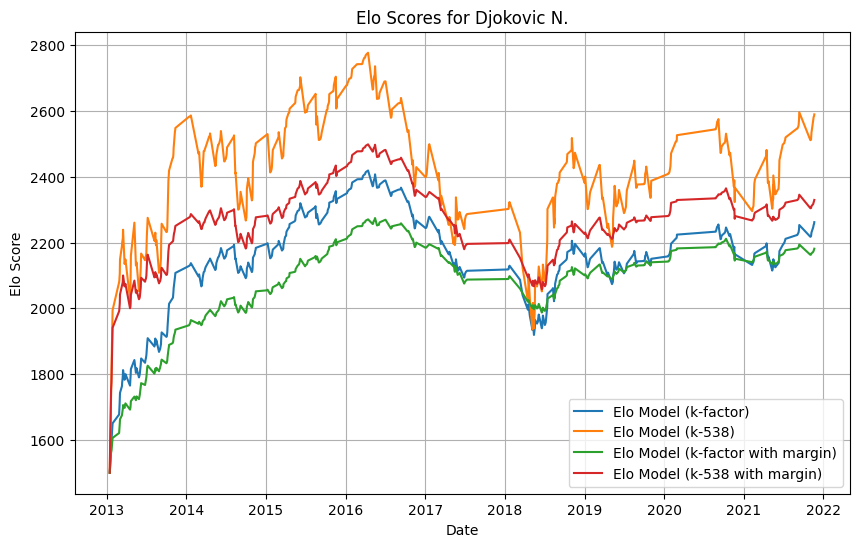

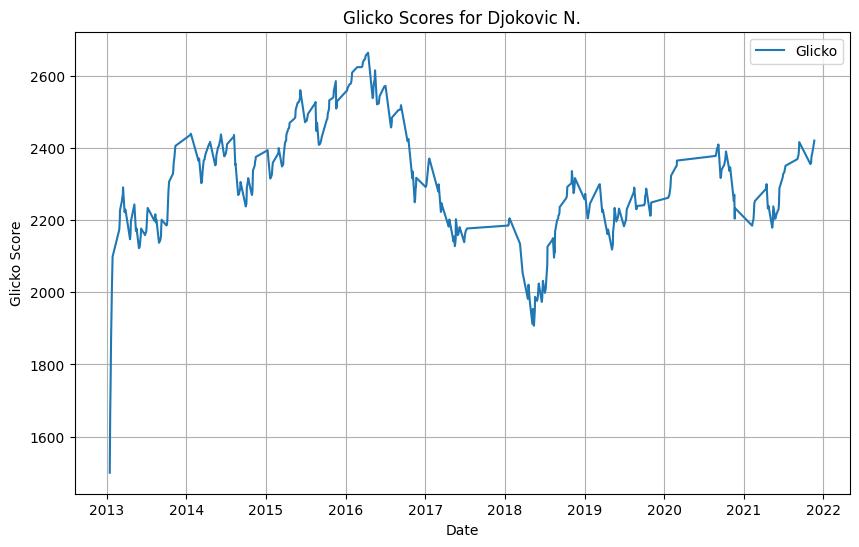

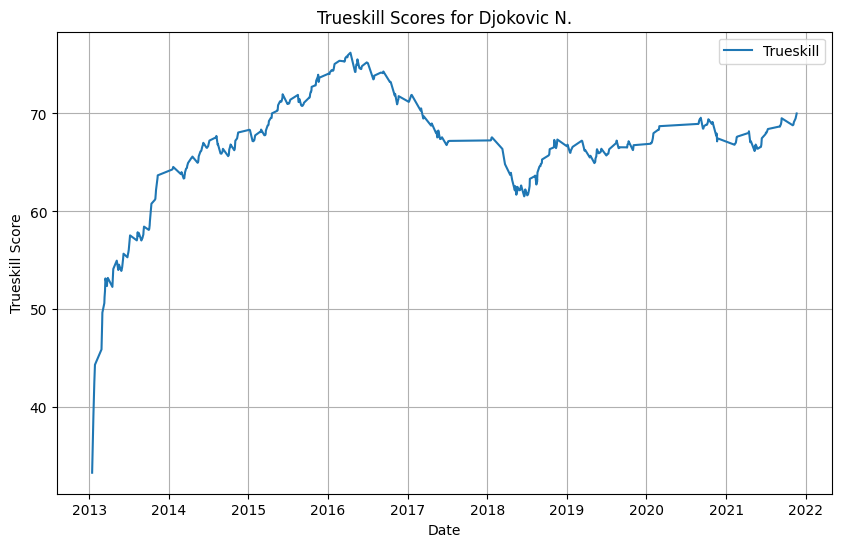

In [94]:
df_glicko_train, glicko_ratings, glicko_rds = implement_glicko(df_train, c=25.74, t=1)
df_trueskill2_train, trueskill_ratings = implement_trueskill2(df_train, mu=50.00, sigma=5.56, beta=10.00, tau=0.39)

df_player_glicko = get_individual_data(df_glicko_train, player_name, "glicko")
df_player_trueskill2 = get_individual_data(df_trueskill2_train, player_name, "trueskill")

df_players = [
    df_player_k_factor,
    df_player_538,
    df_player_k_factor_with_margin,
    df_player_538_with_margin,
    df_player_glicko,
    df_player_trueskill2
]

labels = [
    "Elo Model (k-factor)",
    "Elo Model (k-538)",
    "Elo Model (k-factor with margin)",
    "Elo Model (k-538 with margin)",
    "Glicko",
    "Trueskill"
]

plot_ratings(player_name, [df_player_k_factor, df_player_538, df_player_k_factor_with_margin, df_player_538_with_margin], 
             ["Elo Model (k-factor)", "Elo Model (k-538)", "Elo Model (k-factor with margin)", "Elo Model (k-538 with margin)"], 
             "elo")
plot_ratings(player_name, [df_player_glicko], ["Glicko"], "glicko")
plot_ratings(player_name, [df_player_trueskill2], ["Trueskill"], "trueskill")